In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import Optimizer
import torch.backends.cudnn as cudnn
import torchvision
from torch.utils.data import TensorDataset, DataLoader
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import hypergrad as hg
from itertools import repeat
from poi_util import poison_dataset,patching_test
import poi_util
import dataset_utils
import matplotlib.pyplot as plt
import utils
import train_funcs
%matplotlib inline

In [2]:
device = 'cuda:7'

In [4]:
print('==> Preparing data..')
from torchvision.datasets import CIFAR10
root = './datasets'
dataset = dataset_utils.load_dataset('gtsrb')(batch_size=200, doNormalization=True, inj_rate=0.9)
#testset = CIFAR10(root, train=False, transform=None, download=True)
x_test, y_test = dataset.test.data, dataset.test.targets
x_test = x_test.astype('float32')/255
y_test = np.asarray(y_test)

#attack_name = 'badnets'
#target_lab = '8'
#x_poi_test,y_poi_test= patching_test(x_test, y_test, attack_name, target_lab=target_lab)

y_test = torch.Tensor(y_test.reshape((-1,)).astype(np.int))
#y_poi_test = torch.Tensor(y_poi_test.reshape((-1,)).astype(np.int))

x_test = torch.Tensor(np.transpose(x_test,(0,3,1,2)))
#x_poi_test = torch.Tensor(np.transpose(x_poi_test,(0,3,1,2)))

x_test[:,0] = (x_test[:,0]-0.3403)/0.2724
x_test[:,1] = (x_test[:,1]-0.3121)/0.2608
x_test[:,2] = (x_test[:,2]-0.3214)/0.2669

test_set = TensorDataset(x_test[5000:],y_test[5000:])
unl_set = TensorDataset(x_test[:5000],y_test[:5000])
#att_val_set = TensorDataset(x_poi_test[:5000],y_poi_test[:5000])

#data loader for verifying the clean test accuracy
clnloader = torch.utils.data.DataLoader(
    test_set, batch_size=200, shuffle=False, num_workers=2)

#data loader for verifying the attack success rate
poiloader_cln = torch.utils.data.DataLoader(
    unl_set, batch_size=200, shuffle=False, num_workers=2)

#poiloader = torch.utils.data.DataLoader(
#    att_val_set, batch_size=200, shuffle=False, num_workers=2)
poiloader = dataset.test_backdoor_loader

#data loader for the unlearning step
unlloader = torch.utils.data.DataLoader(
    unl_set, batch_size=200, shuffle=False, num_workers=2)

==> Preparing data..
GTSRB::init - doNormalization is True


/tmp/ipykernel_1611804/588769904.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_test = torch.Tensor(y_test.reshape((-1,)).astype(np.int))


In [3]:
num_classes = 43
input_size = 32
model = utils.get_sdn_model('vgg16',utils.get_add_output('vgg16'),num_classes, input_size)
model.load_state_dict(torch.load('../BackdoorSDN/models/vgg16_gtsrb/copy1/copy5/retrain_sdn_5.pt', map_location=device))
model.eval()
model.to(device=device)

VGG16_SDN(
  (init_conv): Sequential()
  (layers): ModuleList(
    (0): ConvBlockWOutput(
      (layers): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (output): InternalClassifier(
        (flat): Flatten(start_dim=1, end_dim=-1)
        (avg_pool): AvgPool2d(kernel_size=8, stride=8, padding=0)
        (linear): Linear(in_features=1024, out_features=43, bias=True)
      )
    )
    (1): ConvBlockWOutput(
      (layers): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (output): InternalClassifier(
        (flat): Flatten(start_dim=1, end_dim=-1)
        (avg_pool):

In [5]:
asr_original,_  = train_funcs.sdn_test(model, poiloader, device)

In [6]:
asr_original

[0.1836601346731186,
 0.7892974019050598,
 0.9343137741088867,
 0.9486928582191467,
 0.9687908887863159,
 0.9881536364555359,
 0.9692810773849487,
 0.9292483925819397,
 0.8650327324867249,
 0.6367647051811218,
 0.7494281530380249,
 0.882026195526123,
 0.0018790849717333913,
 8.169934881152585e-05,
 0.0001633986976230517]

In [2]:
asr1 = np.array([18.37,10.37,11.18,8.04,14.88,9.44,10.65,7.15,7.23,11.89,9.08])
asr2 = np.array([78.93,51.31,32.13,8.66,0.42,0.25,0.42,0.48,0.32,0.33,0.06])
asr3 = np.array([93.43,90.59,90.16,81.32,62.05,61.10,55.61,65.39,60.38,58.01,47.25])
asr4 = np.array([94.87,88.97,90.78,89.16,82.39,89.14,85.34,86.31,89.84,83.55,84.49])
asr5 = np.array([96.88,96.70,96.53,85.78,87.25,88.46,83.85,86.28,89.59,89.84,85.05])
asr6 = np.array([98.82,98.28,98.91,91.00,93.51,94.89,92.75,93.86,95.34,96.77,93.78])
asr7 = np.array([96.93,95.52,88.25,71.49,71.88,87.85,75.54,70.25,79.35,79.13,80.17])
asr8 = np.array([92.92,92.34,74.53,59.26,57.50,87.62,79.79,70.63,75.25,87.30,80.58])
asr9 = np.array([86.50,75.53,68.69,39.91,53.10,57.65,30.05,64.73,63.99,66.77,62.12])
asr10 = np.array([63.67,42.82,40.00,20.60,31.74,78.98,44.55,45.05,27.48,37.81,53.42])
asr11 = np.array([74.94,44.47,44.51,37.97,28.32,30.74,47.13,41.40,25.73,32.52,44.81])
asr12 = np.array([88.20,51.12,40.93,37.30,28.21,18.44,39.55,33.58,19.20,30.50,31.58])
asr13 = np.array([0,7.11,8.70,15.10,10.89,6.66,12.88,10.23,8.03,12.91,10.86])
asr14 = np.array([0,3,8.96,11.69,10.98,9.28,12.43,10.16,9.34,12.02,10.51])
asr15 = np.array([0,4.17,12.23,11.18,13.19,15.41,12.37,13.74,12.69,15.26,12.52])

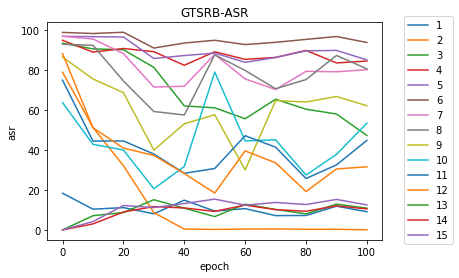

In [3]:
x = np.linspace(0,100,11)
fig,ax = plt.subplots()

ax.plot(x,asr1,label = '1')
ax.plot(x,asr2,label = '2')
ax.plot(x,asr3,label = '3')
ax.plot(x,asr4,label = '4')
ax.plot(x,asr5,label = '5')
ax.plot(x,asr6,label = '6')
ax.plot(x,asr7,label = '7')
ax.plot(x,asr8,label = '8')
ax.plot(x,asr9,label = '9')
ax.plot(x,asr10,label = '10')
ax.plot(x,asr11,label = '11')
ax.plot(x,asr12,label = '12')
ax.plot(x,asr13,label = '13')
ax.plot(x,asr14,label = '14')
ax.plot(x,asr15,label = '15')

ax.set_xlabel('epoch')
ax.set_ylabel('asr')
ax.set_title("GTSRB-ASR")
ax.legend(bbox_to_anchor=(1.05, 1.05))

plt.savefig('./result/gtsrb/asr_cnn.png',dpi=1000, bbox_inches='tight')

## cifar10

In [24]:
asr1 = np.array([1.82,3.48,4.77,3.63,2.81,1.41,2.18,3.51,4.82,3.74,4.21])
asr2 = np.array([26.54,31.09,33.02,31.39,26.84,22.64,24.73,27.88,37.83,31.29,30.59])
asr3 = np.array([72.04,68.96,76.38,58.28,67.53,65.31,59.41,72.03,74.90,70.14,67.96])
asr4 = np.array([84.00,64.52,75.74,75.12,70.86,69.08,76.91,72.77,83.11,68.70,73.29])
asr5 = np.array([86.67,82.47,89.09,83.87,89.54,72.57,84.31,85.99,90.59,81.73,80.06])
asr6 = np.array([93.36,91.46,96.17,90.00,92.93,84.82,90.41,92.66,94.72,90.84,89.69])
asr7 = np.array([97.24,87.59,92.71,83.27,85.04,80.79,85.78,85.26,86.99,79.57,85.52])
asr8 = np.array([96.43,91.51,96.78,89.79,92.44,88.80,88.84,93.88,94.93,70.74,91.53])
asr9 = np.array([96.25,90.10,96.43,89.07,88.34,81.00,85.43,90.72,94.18,69.91,87.92])
asr10 = np.array([95.30,87.60,93.88,78.79,85.12,77.47,73.11,84.13,78.67,64.17,88.61])
asr11 = np.array([94.14,81.48,87.88,76.00,76.83,59.41,59.20,72.32,63.64,61.62,77.67])
asr12 = np.array([91.84,80.28,81.42,70.66,72.73,52.70,55.80,66.40,60.79,56.33,70.10])
asr13 = np.array([0.40,50.43,47.94,58.31,67.19,53.30,54.26,62.43,61.66,53.58,66.29])
asr14 = np.array([0.07,59.89,54.31,64.02,65.54,66.11,66.04,68.19,73.77,64.16,65.61])
asr15 = np.array([0.04,83.77,83.13,59.12,81.76,83.49,83.39,78.93,83.42,81.83,79.04])

In [10]:
font={#'family':'calibri',
     #'style':'italic',  # 斜体，正常条件下注释就行
      'weight':'normal',
      #'color':'red',
      'size':16
}

In [4]:
import matplotlib

In [19]:
#path = 'calibri.ttf'
path = 'CALIBRI.TTF'
matplotlib.font_manager.fontManager.addfont(path)
prop = matplotlib.font_manager.FontProperties(fname=path)

In [20]:
prop.get_name()

'Calibri'

In [21]:
matplotlib.rcParams['font.family'] = prop.get_name()

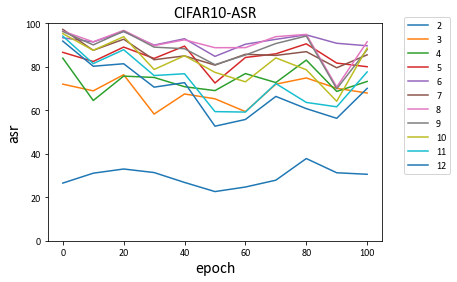

In [27]:
x = np.linspace(0,100,11)
fig,ax = plt.subplots()

#ax.plot(x,asr1,label = '1')
ax.plot(x,asr2,label = '2')
ax.plot(x,asr3,label = '3')
ax.plot(x,asr4,label = '4')
ax.plot(x,asr5,label = '5')
ax.plot(x,asr6,label = '6')
ax.plot(x,asr7,label = '7')
ax.plot(x,asr8,label = '8')
ax.plot(x,asr9,label = '9')
ax.plot(x,asr10,label = '10')
ax.plot(x,asr11,label = '11')
ax.plot(x,asr12,label = '12')
#ax.plot(x,asr13,label = '13')
#ax.plot(x,asr14,label = '14')
#ax.plot(x,asr15,label = '15')

ax.set_xlabel('epoch',fontsize = 16)
ax.set_ylabel('asr',fontsize = 16)
ax.set_title("CIFAR10-ASR",fontsize = 16)

ax.legend(bbox_to_anchor=(1.05, 1.05))
plt.ylim(0,100,5)
#plt.show()
plt.savefig('./result/cifar10/asr_cnn.png',dpi=1000, bbox_inches='tight')